**About** : This notebook is used to train models.

References :
- https://www.kaggle.com/c/imaterialist-fashion-2019-FGVC6/discussion/95247#latest-567841
- https://www.kaggle.com/c/imaterialist-fashion-2019-FGVC6/discussion/95234#latest-555537
- https://www.kaggle.com/c/data-science-bowl-2018/discussion/56326
- https://www.kaggle.com/c/data-science-bowl-2018/discussion/54741


**Models :**

2. DCN -> https://github.com/open-mmlab/mmdetection/tree/master/configs/dcn
3. SCNet ? -> https://github.com/open-mmlab/mmdetection/tree/master/configs/scnet

**TODO :**
- PL trains : 
 - Cascade rx101 freeze + no freeze
 - Cascade r50 nofreeze
 - Cascade b7 freeze

In [1]:
# %load_ext nb_black
%load_ext autoreload
%autoreload 2

In [2]:
cd ../src/

/home/theo/kaggle/sartorius/src


## Initialization

### Imports

In [3]:
import os
import torch
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import *
from tqdm.notebook import tqdm
from collections import Counter
warnings.simplefilter("ignore", UserWarning)

In [4]:
from params import *

from utils.plots import *
from utils.logger import prepare_log_folder, create_logger, save_config

from data.preparation import prepare_data, get_splits, prepare_extra_data
from data.dataset import SartoriusDataset
from data.transforms import get_transfos

from training.main import k_fold
from main_training import BATCH_SIZES

## Data

In [5]:
class Config:
    """
    Parameters used for training
    """
    # Images
    use_mosaic = False
    use_tta = False  # TODO
    data_config = "configs/config_aug_mosaic.py" if use_mosaic else "configs/config_aug.py"
#     data_config = "data/config_rescale.py"

In [6]:
df = prepare_data()

In [7]:
transforms = get_transfos(256, visualize=True)

In [8]:
df.head()

,id,annotation,width,height,cell_type,plate_time,sample_date,sample_id,elapsed_timedelta,img_path,ann,is_extra,plate,well,plate_well,plate_class
0,0030fd0e6378,[118145 6 118849 7 119553 8 120257 8 120961 9 ...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00,../input/train/0030fd0e6378.png,"{'bboxes': [[576, 167, 603, 197], [359, 268, 3...",0,shsy5y[diff],E10,shsy5y[diff]_E10,5
1,0140b3c8f445,[32499 3 33201 7 33902 9 34604 10 35306 11 360...,704,520,astro,09h00m00s,2020-09-13,astros[cereb]_F8-3_Vessel-361_Ph_4,0 days 09:00:00,../input/train/0140b3c8f445.png,"{'bboxes': [[37, 46, 119, 136], [676, 84, 702,...",0,astros[cereb],F8,astros[cereb]_F8,1
2,01ae5a43a2ab,[241026 3 241726 9 242427 13 243130 14 243834 ...,704,520,cort,13h30m00s,2020-11-04,cort[oka-high]_B5-1_Vessel-377_Ph_1,0 days 13:30:00,../input/train/01ae5a43a2ab.png,"{'bboxes': [[248, 342, 264, 363], [445, 405, 4...",0,cort[oka-high],B5,cort[oka-high]_B5,4
3,026b3c2c4b32,[170753 5 171454 12 172158 13 172862 13 173565...,704,520,cort,19h30m00s,2020-11-04,cort[oka-low]_H6-2_Vessel-377_Ph_2,0 days 19:30:00,../input/train/026b3c2c4b32.png,"{'bboxes': [[380, 242, 394, 257], [299, 68, 31...",0,cort[oka-low],H6,cort[oka-low]_H6,2
4,029e5b3b89c7,[139142 7 139845 10 140548 13 141251 15 141955...,704,520,cort,13h30m00s,2020-10-27,cort[pre-treat]_B8-2_Vessel-377_Ph_2,0 days 13:30:00,../input/train/029e5b3b89c7.png,"{'bboxes': [[448, 197, 465, 213], [337, 303, 3...",0,cort[pre-treat],B8,cort[pre-treat]_B8,3


In [9]:
df_extra = prepare_extra_data()

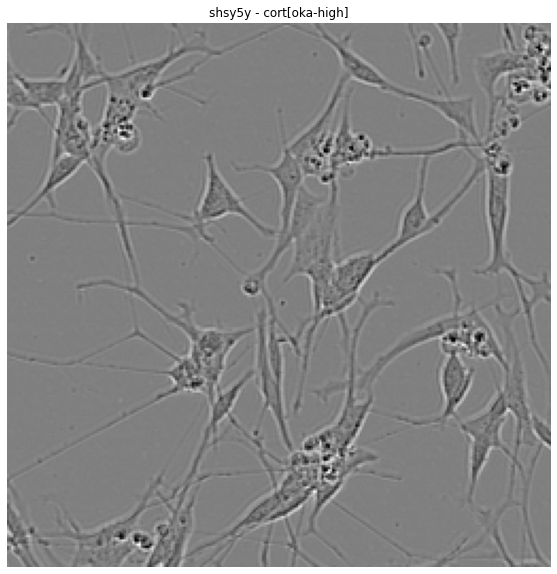

In [10]:
# dataset = SartoriusDataset(df, pipelines['test_viz'], precompute_masks=False)
dataset = SartoriusDataset(
    df_extra.head(10), transforms
)
# dataset.sample_extra_data(10)
# dataset = SartoriusDataset(df, pipelines['train_viz'], precompute_masks=False)


for idx in range(len(dataset)):
    idx = np.random.choice(len(dataset))
    img, y_cell, y_plate = dataset[idx]
    
    img = img.cpu().numpy().transpose(1, 2, 0)
    

    plt.figure(figsize=(10, 10))
    plot_sample(img)
    plt.title(f'{CELL_TYPES[y_cell]} - {PLATES[y_plate]}')
    plt.axis(False)
    plt.show()
    
    break

## Training

In [11]:
class Config:
    """
    Parameters used for training
    """

    # General
    seed = 42
    verbose = 1
    first_epoch_eval = 0
    compute_val_loss = False
    verbose_eval = 5

    device = "cuda" if torch.cuda.is_available() else "cpu"
    save_weights = True

    # Images
    fix = True
    remove_anomalies = True
    size = 256

    extra_name = ""
    use_pl = False

    # k-fold
    split = "gkf"
#     split = "skf"
    k = 5
    random_state = 0
    selected_folds = [0, 1, 2, 3, 4]

    # Model
    encoder = "resnet18"
    freeze_bn = False
    num_classes = 3
    num_classes_aux = len(PLATE_CLASSES)

    # Training
    optimizer = "Adam"
    scheduler = "linear"
    weight_decay = 0
    batch_size = 16
    val_bs = batch_size

    epochs = 10

    lr = 5e-4
    warmup_prop = 0.05

    use_fp16 = False  # TODO

In [12]:
DEBUG = True
log_folder = None

In [13]:
if not DEBUG:
    log_folder = prepare_log_folder(LOG_PATH)
    print(f"Logging results to {log_folder}")
    save_config(Config, log_folder)
    create_logger(directory=log_folder, name="logs.txt")

preds_cell_oof, preds_plate_oof = k_fold(Config, log_folder=log_folder)


-------------   Fold 1 / 5  -------------



Using cache found in /home/theo/.cache/torch/hub/pytorch_vision_v0.6.0


    -> 2066 training images
    -> 509 validation images
    -> 11694129 trainable parameters

Epoch 01/10 	 lr=4.7e-04	 t=7s	loss=0.422
Epoch 02/10 	 lr=4.2e-04	 t=7s	loss=0.200
Epoch 03/10 	 lr=3.7e-04	 t=7s	loss=0.158
Epoch 04/10 	 lr=3.2e-04	 t=7s	loss=0.143
Epoch 05/10 	 lr=2.6e-04	 t=10s	loss=0.090	 avg_val_loss=0.139	 cell_acc=1.000	 plate_acc=0.878
Epoch 06/10 	 lr=2.1e-04	 t=7s	loss=0.075
Epoch 07/10 	 lr=1.6e-04	 t=7s	loss=0.083
Epoch 08/10 	 lr=1.1e-04	 t=7s	loss=0.061
Epoch 09/10 	 lr=5.3e-05	 t=7s	loss=0.044
Epoch 10/10 	 lr=4.1e-07	 t=9s	loss=0.046	 avg_val_loss=0.079	 cell_acc=1.000	 plate_acc=0.927

-------------   Fold 2 / 5  -------------

    -> 2066 training images
    -> 509 validation images
    -> 11694129 trainable parameters



Using cache found in /home/theo/.cache/torch/hub/pytorch_vision_v0.6.0


Epoch 01/10 	 lr=4.7e-04	 t=7s	loss=0.399
Epoch 02/10 	 lr=4.2e-04	 t=7s	loss=0.216
Epoch 03/10 	 lr=3.7e-04	 t=7s	loss=0.186
Epoch 04/10 	 lr=3.2e-04	 t=7s	loss=0.146
Epoch 05/10 	 lr=2.6e-04	 t=9s	loss=0.130	 avg_val_loss=0.039	 cell_acc=1.000	 plate_acc=0.988
Epoch 06/10 	 lr=2.1e-04	 t=7s	loss=0.088
Epoch 07/10 	 lr=1.6e-04	 t=7s	loss=0.084
Epoch 08/10 	 lr=1.1e-04	 t=7s	loss=0.074
Epoch 09/10 	 lr=5.3e-05	 t=7s	loss=0.056
Epoch 10/10 	 lr=4.1e-07	 t=9s	loss=0.051	 avg_val_loss=0.022	 cell_acc=1.000	 plate_acc=0.988

-------------   Fold 3 / 5  -------------

    -> 2066 training images
    -> 509 validation images
    -> 11694129 trainable parameters



Using cache found in /home/theo/.cache/torch/hub/pytorch_vision_v0.6.0


Epoch 01/10 	 lr=4.7e-04	 t=7s	loss=0.383
Epoch 02/10 	 lr=4.2e-04	 t=7s	loss=0.211
Epoch 03/10 	 lr=3.7e-04	 t=7s	loss=0.168
Epoch 04/10 	 lr=3.2e-04	 t=7s	loss=0.134
Epoch 05/10 	 lr=2.6e-04	 t=9s	loss=0.104	 avg_val_loss=0.041	 cell_acc=1.000	 plate_acc=0.978
Epoch 06/10 	 lr=2.1e-04	 t=7s	loss=0.087
Epoch 07/10 	 lr=1.6e-04	 t=7s	loss=0.078
Epoch 08/10 	 lr=1.1e-04	 t=7s	loss=0.068
Epoch 09/10 	 lr=5.3e-05	 t=7s	loss=0.062
Epoch 10/10 	 lr=4.1e-07	 t=9s	loss=0.049	 avg_val_loss=0.027	 cell_acc=1.000	 plate_acc=0.990

-------------   Fold 4 / 5  -------------

    -> 2066 training images
    -> 509 validation images
    -> 11694129 trainable parameters



Using cache found in /home/theo/.cache/torch/hub/pytorch_vision_v0.6.0


Epoch 01/10 	 lr=4.7e-04	 t=7s	loss=0.384
Epoch 02/10 	 lr=4.2e-04	 t=7s	loss=0.223
Epoch 03/10 	 lr=3.7e-04	 t=7s	loss=0.159
Epoch 04/10 	 lr=3.2e-04	 t=7s	loss=0.126
Epoch 05/10 	 lr=2.6e-04	 t=9s	loss=0.110	 avg_val_loss=0.112	 cell_acc=0.994	 plate_acc=0.914
Epoch 06/10 	 lr=2.1e-04	 t=7s	loss=0.105
Epoch 07/10 	 lr=1.6e-04	 t=7s	loss=0.086
Epoch 08/10 	 lr=1.1e-04	 t=7s	loss=0.070
Epoch 09/10 	 lr=5.3e-05	 t=7s	loss=0.060
Epoch 10/10 	 lr=4.1e-07	 t=9s	loss=0.052	 avg_val_loss=0.025	 cell_acc=1.000	 plate_acc=0.994

-------------   Fold 5 / 5  -------------

    -> 2036 training images
    -> 539 validation images
    -> 11694129 trainable parameters



Using cache found in /home/theo/.cache/torch/hub/pytorch_vision_v0.6.0


Epoch 01/10 	 lr=4.7e-04	 t=7s	loss=0.396
Epoch 02/10 	 lr=4.2e-04	 t=7s	loss=0.256
Epoch 03/10 	 lr=3.7e-04	 t=7s	loss=0.148
Epoch 04/10 	 lr=3.2e-04	 t=7s	loss=0.127
Epoch 05/10 	 lr=2.6e-04	 t=9s	loss=0.111	 avg_val_loss=0.099	 cell_acc=1.000	 plate_acc=0.924
Epoch 06/10 	 lr=2.1e-04	 t=7s	loss=0.101
Epoch 07/10 	 lr=1.6e-04	 t=7s	loss=0.085
Epoch 08/10 	 lr=1.1e-04	 t=7s	loss=0.077
Epoch 09/10 	 lr=5.3e-05	 t=7s	loss=0.060
Epoch 10/10 	 lr=8.3e-07	 t=9s	loss=0.059	 avg_val_loss=0.023	 cell_acc=1.000	 plate_acc=0.980


### Results analysis

In [14]:
config = Config

df = prepare_data(fix=False, remove_anomalies=config.remove_anomalies)
df_extra = prepare_extra_data()
df = pd.concat([df, df_extra]).reset_index(drop=True)

if DEBUG:
    splits = get_splits(df, config)
    val_idx = splits[0][1]
#     df = df.iloc[val_idx].copy().reset_index(drop=True)

dataset = SartoriusDataset(df)

In [15]:
print(f'Cell acc :  {accuracy_score(dataset.y_cell, preds_cell_oof.argmax(1)) :.3f}')
print(f'Plate acc :  {accuracy_score(dataset.y_plate, preds_plate_oof.argmax(1)) :.3f}')

Cell acc :  1.000
Plate acc :  0.976


In [16]:
from itertools import product
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(
    y_pred,
    y_true,
    normalize=None,
    display_labels=None,
    cmap="viridis",
):
    """
    Computes and plots a confusion matrix.

    Args:
        y_pred (numpy array): Predictions.
        y_true (numpy array): Truths.
        normalize (bool or None, optional): Whether to normalize the matrix. Defaults to None.
        display_labels (list of strings or None, optional): Axis labels. Defaults to None.
        cmap (str, optional): Colormap name. Defaults to "viridis".
    """
    cm = confusion_matrix(y_true, y_pred, normalize=normalize)
    cm = cm[::-1, :]

    # Display colormap
    n_classes = cm.shape[0]
    im_ = plt.imshow(cm, interpolation="nearest", cmap=cmap)

    # Display values
    cmap_min, cmap_max = im_.cmap(0), im_.cmap(256)
    thresh = (cm.max() + cm.min()) / 2.0
    for i, j in product(range(n_classes), range(n_classes)):
        color = cmap_max if cm[i, j] < thresh else cmap_min
        text = f"{cm[i, j]:.0f}" if normalize is None else f"{cm[i, j]:.3f}"
        plt.text(
            j, i, text, ha="center", va="center", color=color
        )

    # Display legend
    plt.xlim(-0.5, n_classes - 0.5)
    plt.ylim(-0.5, n_classes - 0.5)
    plt.xticks(np.arange(n_classes), display_labels, rotation=45)
    plt.yticks(np.arange(n_classes), display_labels[::-1])

    plt.ylabel("True label", fontsize=12)
    plt.xlabel("Predicted label", fontsize=12)


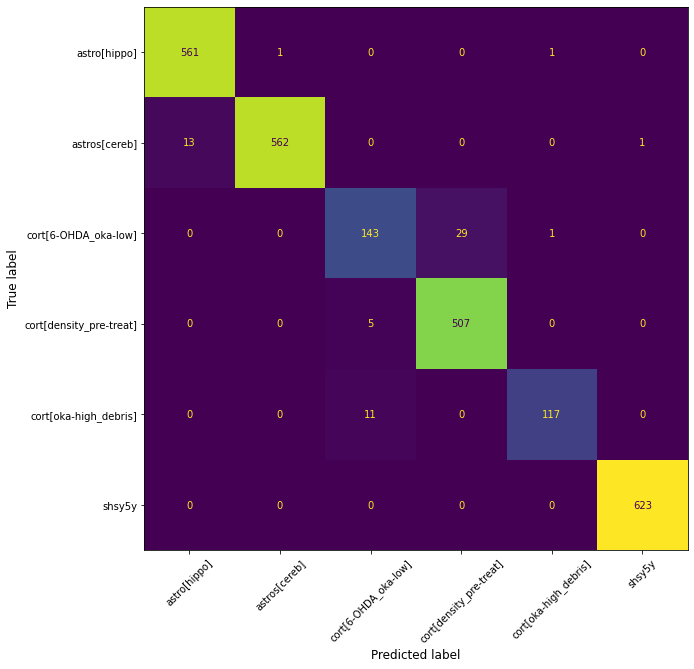

In [17]:
plt.figure(figsize=(10, 10))
cm = plot_confusion_matrix(preds_plate_oof.argmax(1), dataset.y_plate, display_labels=PLATE_CLASSES)

In [18]:
df["pred_plate"] = preds_plate_oof.argmax(1)

In [19]:
df_ = df[df['is_extra'] == 0]
np.save("../output/pred_plate.npy", df_["pred_plate"].values)
Counter(df_["pred_plate"].values)

In [20]:
dfg = df.groupby('plate').agg(list)[['pred_plate']]
dfg['pred_plate'] = dfg['pred_plate'].apply(Counter)
dfg

,pred_plate
plate,
astro[hippo],"{0: 561, 1: 1, 4: 1}"
astros[cereb],"{1: 562, 0: 13, 5: 1}"
cort[6-OHDA],"{2: 99, 3: 25, 4: 1}"
cort[debris],"{2: 11, 4: 21}"
cort[density],"{3: 379, 2: 5}"
cort[oka-high],{4: 96}
cort[oka-low],"{2: 44, 3: 4}"
cort[pre-treat],{3: 128}
shsy5y[diff],{5: 623}


In [21]:
dfg = df.groupby('plate').agg(list)[["well"]]
dfg['well'] = dfg['well'].apply(np.unique)
dfg

,well
plate,
astro[hippo],"[D1, D3, E2, E3, F2, F3, F5, G1, G2, G3, H3, H6]"
astros[cereb],"[D7, D9, E8, E9, F11, F12, F8, G10, G11, G12, ..."
cort[6-OHDA],"[B1, G2]"
cort[debris],[D9]
cort[density],"[A10, A9, B11, B7, C11, C6]"
cort[oka-high],"[B5, B6]"
cort[oka-low],[H6]
cort[pre-treat],"[A4, B8]"
shsy5y[diff],"[D1, D10, D11, D12, D3, D4, D5, D7, D9, E1, E1..."
